### Task Explanation

 we will implement, train and evaluate a neural network using pyTorch on wheat disease classification problem. 

Wheat rust is a devastating plant disease that affects many crops, reducing yields and affecting the livelihoods of farmers and decreasing food security across the continent. The disease is difficult to monitor at a large scale, making it difficult to control and eradicate.

The objective of this challenge is to build a machine learning algorithm to correctly classify if a plant is healthy, has stem rust, or has leaf rust.

In [1]:

# any other imports that you may require
import matplotlib.pyplot as plt
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import glob
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Hyperparameters

You can play with these to improve accuracy on test data.

In [3]:
batch_size = 32
epochs = 25
learning_rate = 0.0001
input_shape = (3,256,256)

### Data

Get Wheat Disease Data for training and testing

In [4]:
!git clone https://github.com/MMFa666/WheatDiseaseDataset.git

Cloning into 'WheatDiseaseDataset'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 386.05 MiB | 18.11 MiB/s, done.
Checking out files: 100% (877/877), done.


Get paths for all the training images in the dataset and print the length of training_paths list. For this purpose you can use glob. You can have a look [here](https://www.geeksforgeeks.org/how-to-use-glob-function-to-find-files-recursively-in-python/) on how to use glob.

In [5]:
training_paths = list()
for name in glob.glob("/content/WheatDiseaseDataset/train/*",recursive=True):
  print(name)
  for files in glob.glob(name + "/*",recursive=True):
    training_paths.append(files)
print(len(training_paths))

/content/WheatDiseaseDataset/train/stem_rust
/content/WheatDiseaseDataset/train/leaf_rust
/content/WheatDiseaseDataset/train/healthy_wheat
699


In [6]:
#printing path of training dateset
for i in training_paths:
  print(i)


/content/WheatDiseaseDataset/train/stem_rust/HMDOKP.jpg
/content/WheatDiseaseDataset/train/stem_rust/120LEV.jpg
/content/WheatDiseaseDataset/train/stem_rust/D9D9YO.jpg
/content/WheatDiseaseDataset/train/stem_rust/4D5Z4N.jpg
/content/WheatDiseaseDataset/train/stem_rust/1NFNZD.jpg
/content/WheatDiseaseDataset/train/stem_rust/2NKA0A.jpg
/content/WheatDiseaseDataset/train/stem_rust/B0VR65.jpg
/content/WheatDiseaseDataset/train/stem_rust/4PS17R.jpg
/content/WheatDiseaseDataset/train/stem_rust/05R4FK.jpg
/content/WheatDiseaseDataset/train/stem_rust/FLY31D.jpg
/content/WheatDiseaseDataset/train/stem_rust/DLZR23.jpg
/content/WheatDiseaseDataset/train/stem_rust/XFVHN1.jpg
/content/WheatDiseaseDataset/train/stem_rust/M6HZIP.jpg
/content/WheatDiseaseDataset/train/stem_rust/31LDUR.jpg
/content/WheatDiseaseDataset/train/stem_rust/7AJXG3.jpg
/content/WheatDiseaseDataset/train/stem_rust/55E81Z.jpg
/content/WheatDiseaseDataset/train/stem_rust/RHWEMM.jpg
/content/WheatDiseaseDataset/train/stem_rust/FPO

In [7]:
#Testing the splitting
sp = training_paths[0].split('/')
print(sp[4])

stem_rust


Do the same for testing data images.

In [8]:
# code here
test_paths = list()
for name in glob.glob("/content/WheatDiseaseDataset/test/*",recursive=True):
  for files in glob.glob(name + "/*",recursive=True):
    print(files)
    test_paths.append(files)
print(len(test_paths))

/content/WheatDiseaseDataset/test/stem_rust/U79432.jpg
/content/WheatDiseaseDataset/test/stem_rust/KFTIM5.jpg
/content/WheatDiseaseDataset/test/stem_rust/C74T9S.jpg
/content/WheatDiseaseDataset/test/stem_rust/3T864F.jpg
/content/WheatDiseaseDataset/test/stem_rust/9SLSPS.jpg
/content/WheatDiseaseDataset/test/stem_rust/68K0BF.jpg
/content/WheatDiseaseDataset/test/stem_rust/IUE37D.jpg
/content/WheatDiseaseDataset/test/stem_rust/UZY77Z.jpg
/content/WheatDiseaseDataset/test/stem_rust/5RG24C.jpg
/content/WheatDiseaseDataset/test/stem_rust/16DV3Z.jpg
/content/WheatDiseaseDataset/test/stem_rust/RJAAIW.jpg
/content/WheatDiseaseDataset/test/stem_rust/WQG8SV.jpg
/content/WheatDiseaseDataset/test/stem_rust/1CQ95E.jpg
/content/WheatDiseaseDataset/test/stem_rust/VDO10F.jpg
/content/WheatDiseaseDataset/test/stem_rust/FFV2P1.jpg
/content/WheatDiseaseDataset/test/stem_rust/P10VUX.jpg
/content/WheatDiseaseDataset/test/stem_rust/SMXQG3.jpg
/content/WheatDiseaseDataset/test/stem_rust/GSMGBN.jpg
/content/W

### Labels

In [9]:
my_labels={}
my_labels['healthy_wheat'] = 0
my_labels['leaf_rust'] = 1
my_labels['stem_rust'] = 2
print(my_labels)

{'healthy_wheat': 0, 'leaf_rust': 1, 'stem_rust': 2}


### Preprocessing

Preprocessing of data such as normalization, mean shift, make the learning task simple for network and could accelerate the training process. In this task, we will only do normaliztion.

In images, pixel values range from 0 to 255. To shift the values between (0,1) range, divide input image by 255.


In [10]:
def preprocessing_norm(images):
    return np.divide(images,255)

In [11]:
# Data generator function here.
def batch_generator(training_paths):
  train_list = list()
  # Reading the images in a numpy array
  for i in range(len(training_paths)):
    img = cv2.imread(training_paths[i]).astype("float32")
    # Resizing the images to the input shape
    img.resize(256,256,3)
    #preprocessing the images
    img = preprocessing_norm(img)
    #Taking transporse to convert (256x256x3) to (3x256x256)
    img = np.transpose(img)
    #Making the list for tuples
    train_list.append((img,my_labels[training_paths[i].split('/')[4]]))
  return train_list






In [12]:
# code here
train_dataloader = DataLoader(batch_generator(training_paths), batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



In [13]:
print(len(train_dataloader))
print(train_dataloader)

22


In [14]:
# code here
#Dense layer are basically the linear layers
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(3,256,kernel_size=5,stride = 2,padding=0)
    self.batchnorm1 = nn.BatchNorm2d(256)
    self.relu = nn.ReLU(inplace = True)
    self.drop1 = nn.Dropout(0.2)
    #Second conv layer
    self.conv2 = nn.Conv2d(256,128,kernel_size=3,stride = 2,padding=0)
    self.batchnorm2 = nn.BatchNorm2d(128)
    #Third Conv layer
    self.conv3 = nn.Conv2d(128,64,kernel_size=3,stride = 2,padding=0)
    self.batchnorm3 = nn.BatchNorm2d(64)
    #Fourth Conv layer
    self.conv4 = nn.Conv2d(64,32,kernel_size=3,stride = 2,padding=0)
    self.batchnorm4 = nn.BatchNorm2d(32)
    #fifth Conv layer 
    self.conv5 = nn.Conv2d(32,16,kernel_size=3,stride = 2,padding=0)
    self.batchnorm5 = nn.BatchNorm2d(16)

    self.linear1 = nn.Linear(576,32)
    self.linear2 = nn.Linear(32,3)

  def forward(self,x):
    x = self.drop1(self.relu(self.batchnorm1(self.conv1(x))))
    x = self.drop1(self.relu(self.batchnorm2(self.conv2(x))))
    x = self.drop1(self.relu(self.batchnorm3(self.conv3(x))))
    x = self.drop1(self.relu(self.batchnorm4(self.conv4(x))))
    x = self.drop1(self.relu(self.batchnorm5(self.conv5(x))))
    x = torch.flatten(x,start_dim=1)
    x = self.drop1(self.relu(self.linear1(x)))
    x = self.linear2(x)

    return x








Initialize network and cast it to device declared above. (Hint: net.to(device) )

In [15]:
# code here
net = Net()
net.to(device)




Net(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=576, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

In [16]:
#print model summary here
summary(net,(input_shape))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
       BatchNorm2d-2        [-1, 256, 126, 126]             512
              ReLU-3        [-1, 256, 126, 126]               0
           Dropout-4        [-1, 256, 126, 126]               0
            Conv2d-5          [-1, 128, 62, 62]         295,040
       BatchNorm2d-6          [-1, 128, 62, 62]             256
              ReLU-7          [-1, 128, 62, 62]               0
           Dropout-8          [-1, 128, 62, 62]               0
            Conv2d-9           [-1, 64, 30, 30]          73,792
      BatchNorm2d-10           [-1, 64, 30, 30]             128
             ReLU-11           [-1, 64, 30, 30]               0
          Dropout-12           [-1, 64, 30, 30]               0
           Conv2d-13           [-1, 32, 14, 14]          18,464
      BatchNorm2d-14           [-1, 32,

Define [CrossEntropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [RMSprop](https://pytorch.org/docs/stable/optim.html#:~:text=Implements%20RAdam%20algorithm.-,RMSprop,-Implements%20RMSprop%20algorithm) optimizer here. (Hint: See the links to understand how to do this.)

In [17]:
# Code here
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
# Intialize num_training_batches.
num_training_batches = 100


Train the network here. You can have look [here](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=0.001%2C%20momentum%3D0.9) to understand how to do this. Remember to convert your data and labels to pytorch tensors and cast to device before passing it to the network. Also, record the training loss for plotting purposes.

In [19]:
temp = list()
for epoch in range(epochs):
  running_loss =0.0
  for i , data in enumerate(train_dataloader,0):
    inputs ,labels = data
    inputs = inputs.to(device)
    labels = torch.tensor(labels)
    labels =labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  last_loss = running_loss / 32 # loss per batch
  print("Loss epoch = {} loss {}".format(epoch,last_loss))
  temp.append(last_loss)
  running_loss = 0

    
print(temp)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Loss epoch = 0 loss 0.7736261412501335
Loss epoch = 1 loss 0.6985497083514929
Loss epoch = 2 loss 0.64127884991467
Loss epoch = 3 loss 0.6489718426018953
Loss epoch = 4 loss 0.6250562928617001
Loss epoch = 5 loss 0.6103909257799387
Loss epoch = 6 loss 0.6018358282744884
Loss epoch = 7 loss 0.5837474334985018
Loss epoch = 8 loss 0.5855809710919857
Loss epoch = 9 loss 0.5819701440632343
Loss epoch = 10 loss 0.5664568524807692
Loss epoch = 11 loss 0.5615800227969885
Loss epoch = 12 loss 0.545589093118906
Loss epoch = 13 loss 0.5368403699249029
Loss epoch = 14 loss 0.5250109061598778
Loss epoch = 15 loss 0.5242227986454964
Loss epoch = 16 loss 0.4978689346462488
Loss epoch = 17 loss 0.5099400356411934
Loss epoch = 18 loss 0.483019445091486
Loss epoch = 19 loss 0.46489704959094524
Loss epoch = 20 loss 0.4266720488667488
Loss epoch = 21 loss 0.43013670295476913
Loss epoch = 22 loss 0.3931772196665406
Loss epoch = 23 loss 0.37965742964297533
Loss epoch = 24 loss 0.35901068802922964
[0.7736261

Plot the loss graph of training.

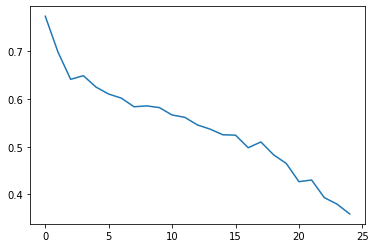

In [20]:
# Loss Plot
x = np.array([_ for _ in range(0,25)])
y = np.array(temp)
plt.plot(x, y)
plt.show()

### Evaluation

In [21]:
# code here
test_dataloader = DataLoader(batch_generator(test_paths), batch_size=batch_size, shuffle=True)

Put the network in eval mode using your_model.eval()

In [22]:
# code here
net.eval()

Net(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (batchnorm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (drop1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
  (batchnorm5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=576, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

Now, make predictions on test data. Cast the outputs to cpu and convert to numpy (using outputs.cpu().numpy()). If you get memory error then you can loop over all images one by one and then make and store the prediction.

In [23]:
# code here
correct = 0
total = 0 
ground = list()
Predic = list()
with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data
    ground.append(labels.cpu().numpy())
    inputs = inputs.to(device)
    labels =labels.to(device)
    outputs = net(inputs)
    print(outputs)
    _, predicted = torch.max(outputs.data, 1)
    Predic.append(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

tensor([[ 4.8367e+00, -5.5388e-01, -4.3176e+00],
        [ 2.3694e-01, -1.7971e+00,  2.6971e-01],
        [-1.1616e+00, -8.8864e-01,  7.6359e-01],
        [-3.2950e+00,  1.7656e+00,  9.0886e-01],
        [-2.4617e+00,  1.5098e+00,  6.1796e-01],
        [-3.7922e+00, -1.1961e+00,  2.1791e+00],
        [-4.9417e+00,  1.4112e+00,  2.7702e+00],
        [ 1.3048e+00, -1.1974e+00, -2.1207e-01],
        [-9.9183e-01,  4.0493e-02,  1.8874e-01],
        [ 9.9810e-01, -5.0611e-03, -9.1259e-01],
        [-3.5992e+00,  3.0094e+00,  1.1142e+00],
        [-2.5058e+00,  1.7219e+00,  7.4377e-01],
        [-4.3953e-01, -8.0867e-01,  3.5774e-01],
        [-2.3847e+00, -9.0584e-01,  8.9096e-01],
        [-1.3388e+00, -3.8489e+00,  1.8986e+00],
        [-4.7183e+00,  1.4192e+00,  1.8168e+00],
        [-4.6126e+00,  1.9599e+00,  1.0621e+00],
        [-2.5363e-01,  6.0998e+00,  1.8556e+00],
        [-7.2109e+00,  2.9946e+00,  2.6038e+00],
        [-2.6625e+00, -8.4805e-01,  1.0146e+00],
        [-3.6477e+00

Calculate and print accuracy.

In [25]:
# code here
print("accuracy = ", correct/total)

accuracy =  0.672316384180791


In [26]:
# code here
print(ground[0][0])
truth_label = list()
predicted_label = list()
for i in range(len(ground)):
  for j in range(len(ground[i])):
    truth_label.append(ground[i][j])
    predicted_label.append(Predic[i][j])

cm = confusion_matrix(truth_label,predicted_label)

0


In [27]:
def plot_confusion_matrix(conf_mat):
    classes = list(my_labels.keys())
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

Use the above function to plot confusion matrix here.

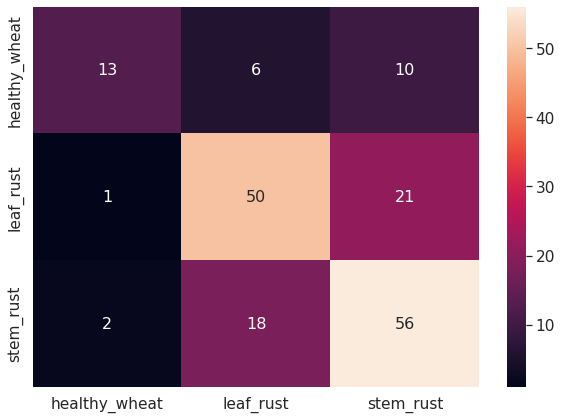

In [28]:
# code here
plot_confusion_matrix(cm)

### Task 2 Adding skip connection





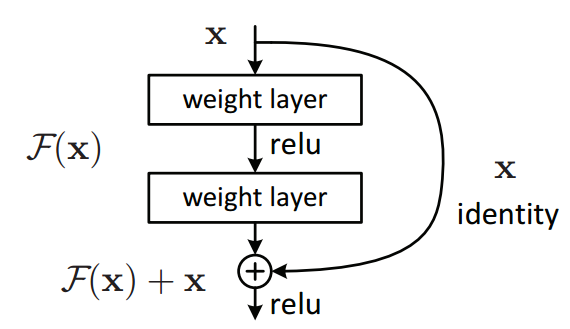

Define Network class

In [29]:
# Code here
# code here
#Dense layer are basically the linear layers
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #First Conv Layer
    self.conv2d_25 = nn.Conv2d(3,64,kernel_size=5,stride = 2,padding=0)
    self.bn_conv1 = nn.BatchNorm2d(64)

    #Second conv layer
    self.conv2d_26 = nn.Conv2d(64,64,kernel_size=1,stride = 1,padding=0)
    self.bn_conv2 = nn.BatchNorm2d(64)

    # Activation + Leaky Relu + Dropout + add
    self.activation = nn.ReLU(inplace = True)
    self.leaky_relu = nn.LeakyReLU(inplace = True)
    self.drop = nn.Dropout(0.2)



    self.linear1 = nn.Linear(1016064,32)
    self.linear2 = nn.Linear(32,3)

  def forward(self,x):
    x = self.drop(self.activation(self.bn_conv1(self.conv2d_25(x))))
    x_copy = x.detach().clone()
    x = self.drop(self.activation(self.bn_conv2(self.conv2d_26(x))))
    x = x + self.drop(x_copy)
    x = torch.flatten(x,start_dim=1)
    x = self.drop(self.leaky_relu(self.linear1(x)))
    x = self.linear2(x)

    return x








Initialize model and cast it to device

In [30]:
# Code here
net = Net()
net.to(device)

Net(
  (conv2d_25): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_26): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn_conv2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (drop): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=1016064, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

Print Summary

In [31]:
# Code here
summary(net,(input_shape))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 126, 126]           4,864
       BatchNorm2d-2         [-1, 64, 126, 126]             128
              ReLU-3         [-1, 64, 126, 126]               0
           Dropout-4         [-1, 64, 126, 126]               0
            Conv2d-5         [-1, 64, 126, 126]           4,160
       BatchNorm2d-6         [-1, 64, 126, 126]             128
              ReLU-7         [-1, 64, 126, 126]               0
           Dropout-8         [-1, 64, 126, 126]               0
           Dropout-9         [-1, 64, 126, 126]               0
           Linear-10                   [-1, 32]      32,514,080
        LeakyReLU-11                   [-1, 32]               0
          Dropout-12                   [-1, 32]               0
           Linear-13                    [-1, 3]              99
Total params: 32,523,459
Trainable para

Define loss, optimizer and train the new model 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Loss epoch = 0 loss 34.095420993864536
Loss epoch = 1 loss 3.138595663011074
Loss epoch = 2 loss 2.8050060272216797
Loss epoch = 3 loss 2.420453976839781
Loss epoch = 4 loss 2.3116458877921104
Loss epoch = 5 loss 1.8763473145663738
Loss epoch = 6 loss 1.789763256907463
Loss epoch = 7 loss 1.7157734595239162
Loss epoch = 8 loss 2.1631523221731186
Loss epoch = 9 loss 2.296757910400629
Loss epoch = 10 loss 2.080529071390629
Loss epoch = 11 loss 1.7933993265032768
Loss epoch = 12 loss 1.4414371475577354
Loss epoch = 13 loss 1.0995683129876852
Loss epoch = 14 loss 1.41240216139704
Loss epoch = 15 loss 2.6401601135730743
Loss epoch = 16 loss 2.096419770270586
Loss epoch = 17 loss 1.5921991243958473
Loss epoch = 18 loss 1.109617866575718
Loss epoch = 19 loss 0.9732492621988058
Loss epoch = 20 loss 0.7351155122742057
Loss epoch = 21 loss 0.8507338035851717
Loss epoch = 22 loss 0.48282085452228785
Loss epoch = 23 loss 0.5381698748096824
Loss epoch = 24 loss 0.4905036026611924
[34.09542099386453

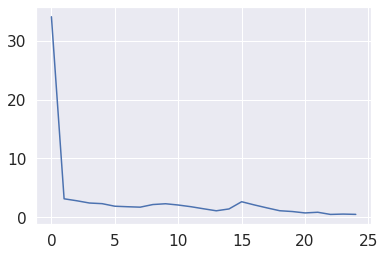

In [32]:
# Code here
# Code here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
temp = list()
for epoch in range(epochs):
  running_loss =0.0
  for i , data in enumerate(train_dataloader,0):
    inputs ,labels = data
    inputs = inputs.to(device)
    labels = torch.tensor(labels)
    labels =labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  last_loss = running_loss / 32 # loss per batch
  print("Loss epoch = {} loss {}".format(epoch,last_loss))
  temp.append(last_loss)
  running_loss = 0

    
print(temp)
# Loss Plot
x = np.array([_ for _ in range(0,25)])
y = np.array(temp)
plt.plot(x, y)
plt.show()

Make preditions, extract labels, calculate accuracy and plot confusion matrix as done in Task 1.

In [33]:
net.eval()

Net(
  (conv2d_25): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2))
  (bn_conv1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_26): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (bn_conv2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (drop): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=1016064, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

In [34]:
# Code here
# code here
correct = 0
total = 0 
ground = list()
Predic = list()
with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data
    ground.append(labels.cpu().numpy())
    inputs = inputs.to(device)
    labels =labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    Predic.append(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
#print Accuracy 


In [35]:
# code here
print(ground[0][0])
truth_label = list()
predicted_label = list()
for i in range(len(ground)):
  for j in range(len(ground[i])):
    truth_label.append(ground[i][j])
    predicted_label.append(Predic[i][j])
print("Accuracy : {} ".format(accuracy_score(truth_label,predicted_label)))
cm = confusion_matrix(truth_label,predicted_label)

0
Accuracy : 0.6045197740112994 


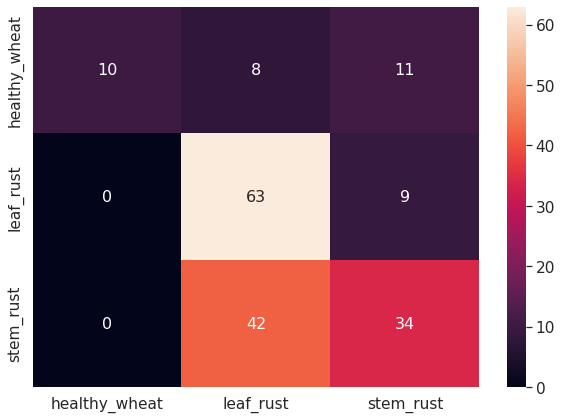

In [36]:
# code here
plot_confusion_matrix(cm)

### Task 3 improving model

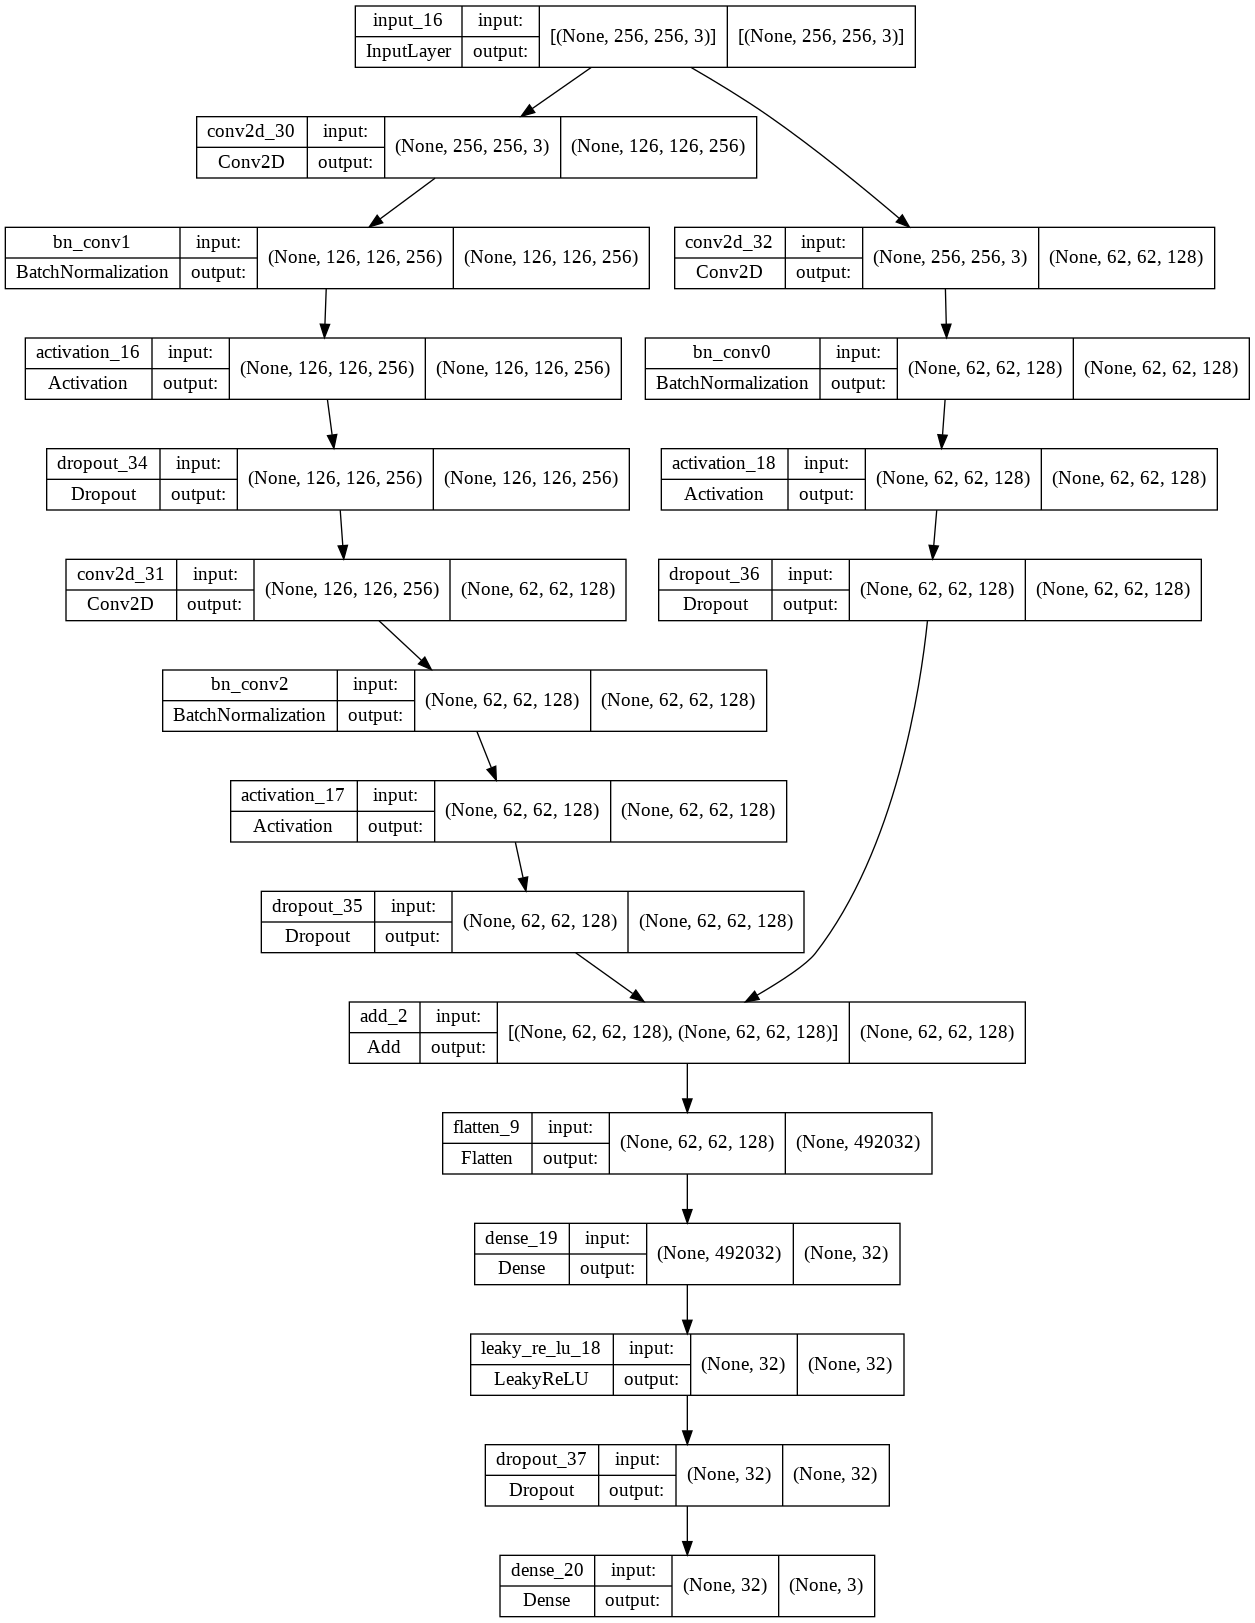

Define Network class

In [37]:
# Code here
# code here
#Dense layer are basically the linear layers
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    #First Conv Layer
    self.conv2d_30 = nn.Conv2d(3,256,kernel_size=5,stride = 2,padding=0)
    self.bn_conv1 = nn.BatchNorm2d(256)

    #Second conv layer
    self.conv2d_31 = nn.Conv2d(256,128,kernel_size=3,stride = 2,padding=0)
    self.bn_conv2 = nn.BatchNorm2d(128)
    #Third conv layer
    self.conv2d_32 = nn.Conv2d(3,128,kernel_size=12,stride = 4,padding=0)
    self.bn_conv0 = nn.BatchNorm2d(128)

    # Activation + Leaky Relu + Dropout + add
    self.activation = nn.ReLU(inplace = True)
    self.leaky_relu = nn.LeakyReLU(inplace = True)
    self.drop = nn.Dropout(0.2)



    self.linear1 = nn.Linear(492032,32)
    self.linear2 = nn.Linear(32,3)

  def forward(self,x):
    x_copy = x.detach().clone()
    x_copy = self.conv2d_30(x_copy)
    x_copy = self.drop(self.activation(self.bn_conv0(self.conv2d_32(x))))

    x = self.drop(self.activation(self.bn_conv1(self.conv2d_30(x))))
    x = self.drop(self.activation(self.bn_conv2(self.conv2d_31(x))))
    x = x + self.drop(x_copy)
    x = torch.flatten(x,start_dim=1)
    x = self.drop(self.leaky_relu(self.linear1(x)))
    x = self.linear2(x)

    return x








Initialize model and cast it to device.

In [38]:
# Code here
# Code here
net = Net()
net.to(device)

Net(
  (conv2d_30): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (bn_conv1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_31): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_32): Conv2d(3, 128, kernel_size=(12, 12), stride=(4, 4))
  (bn_conv0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (drop): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=492032, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

Print Summary

In [39]:
# Code here
# Code here
summary(net,(input_shape))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 256, 126, 126]          19,456
            Conv2d-2          [-1, 128, 62, 62]          55,424
       BatchNorm2d-3          [-1, 128, 62, 62]             256
              ReLU-4          [-1, 128, 62, 62]               0
           Dropout-5          [-1, 128, 62, 62]               0
            Conv2d-6        [-1, 256, 126, 126]          19,456
       BatchNorm2d-7        [-1, 256, 126, 126]             512
              ReLU-8        [-1, 256, 126, 126]               0
           Dropout-9        [-1, 256, 126, 126]               0
           Conv2d-10          [-1, 128, 62, 62]         295,040
      BatchNorm2d-11          [-1, 128, 62, 62]             256
             ReLU-12          [-1, 128, 62, 62]               0
          Dropout-13          [-1, 128, 62, 62]               0
          Dropout-14          [-1, 128,

Define loss, optimizer and train model.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


Loss epoch = 0 loss 9.963576890528202
Loss epoch = 1 loss 2.113573085516691
Loss epoch = 2 loss 2.278988227248192
Loss epoch = 3 loss 1.8037185817956924
Loss epoch = 4 loss 1.6096842549741268
Loss epoch = 5 loss 1.4774628914892673
Loss epoch = 6 loss 1.3789508156478405
Loss epoch = 7 loss 1.280856117606163
Loss epoch = 8 loss 1.3281578570604324
Loss epoch = 9 loss 1.3346916865557432
Loss epoch = 10 loss 1.1687190160155296
Loss epoch = 11 loss 0.9812344126403332
Loss epoch = 12 loss 0.9845042675733566
Loss epoch = 13 loss 0.9694402497261763
Loss epoch = 14 loss 0.8203059379011393
Loss epoch = 15 loss 0.757239431142807
Loss epoch = 16 loss 0.8774334322661161
Loss epoch = 17 loss 0.8301879875361919
Loss epoch = 18 loss 0.7257808931171894
Loss epoch = 19 loss 0.6071766577661037
Loss epoch = 20 loss 0.7196000497788191
Loss epoch = 21 loss 0.6540045849978924
Loss epoch = 22 loss 0.6014591511338949
Loss epoch = 23 loss 0.5439479742199183
Loss epoch = 24 loss 0.5292405756190419
[9.963576890528

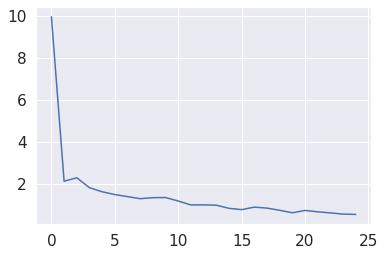

In [40]:
# Code here
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
temp = list()
for epoch in range(epochs):
  running_loss =0.0
  for i , data in enumerate(train_dataloader,0):
    inputs ,labels = data
    inputs = inputs.to(device)
    labels = torch.tensor(labels)
    labels =labels.to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  last_loss = running_loss / 32 # loss per batch
  print("Loss epoch = {} loss {}".format(epoch,last_loss))
  temp.append(last_loss)
  running_loss = 0

    
print(temp)
# Loss Plot
x = np.array([_ for _ in range(0,25)])
y = np.array(temp)
plt.plot(x, y)
plt.show()

In [41]:
net.eval()

Net(
  (conv2d_30): Conv2d(3, 256, kernel_size=(5, 5), stride=(2, 2))
  (bn_conv1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_31): Conv2d(256, 128, kernel_size=(3, 3), stride=(2, 2))
  (bn_conv2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2d_32): Conv2d(3, 128, kernel_size=(12, 12), stride=(4, 4))
  (bn_conv0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU(inplace=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (drop): Dropout(p=0.2, inplace=False)
  (linear1): Linear(in_features=492032, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=3, bias=True)
)

Make preditions, extract labels, calculate accuracy and plot confusion matrix as done in Task 1.

In [42]:
# Code here
correct = 0
total = 0 
ground = list()
Predic = list()
with torch.no_grad():
  for data in test_dataloader:
    inputs, labels = data
    ground.append(labels.cpu().numpy())
    inputs = inputs.to(device)
    labels =labels.to(device)
    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    Predic.append(predicted.cpu().numpy())
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
#print Accuracy 
# code here
print(ground[0][0])
truth_label = list()
predicted_label = list()
for i in range(len(ground)):
  for j in range(len(ground[i])):
    truth_label.append(ground[i][j])
    predicted_label.append(Predic[i][j])
print("Accuracy : {} ".format(accuracy_score(truth_label,predicted_label)))
cm = confusion_matrix(truth_label,predicted_label)


1
Accuracy : 0.6779661016949152 
